<a href="https://colab.research.google.com/github/habibur8rahaman/Sentiment-Classification-in-Tourist-Reviews/blob/main/SentimentAnalysis_with_CNN_and_RNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Plan of Action


1.   Load **IMDb Movie Reviews dataset (50,000 reviews)**
2.   **Pre-process dataset** by removing special characters, numbers, etc. from user reviews + convert **sentiment labels** positive & negative to numbers 1 & 0, respectively
3.   **Import GloVe Word Embedding** to build Embedding Dictionary + Use this to build Embedding Matrix for our Corpus
4. Model Training using **Deep Learning in Keras** for separate: **Simple Neural Net, CNN and LSTM Models** and analyse model performance and results
4. Last, perform **predictions on real IMDb movie reviews**

## Setting the environment

In [1]:
# Mounting google drive

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
# Setting toolkit folder as working directory

%cd /content/drive/My Drive/CNN
! ls

/content/drive/My Drive/CNN
 a1_IMDB_Dataset.csv		 c1_lstm_model_acc_0.836.h5	 'CNN Results.csv'
 a2_glove.6B.100d.txt		 c1_lstm_model_acc_0.85.h5	 'hotel reviews.csv'
'attraction spots reviews.csv'	 c2_IMDb_Unseen_Predictions.csv  'RNN Results.csv'


In [3]:
# Importing essential libraries and functions

import pandas as pd
import numpy as np
import re
import nltk
from nltk.corpus import stopwords
from numpy import array

from keras.preprocessing.text import one_hot, Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Activation, Dropout, Dense
from keras.layers import Flatten, GlobalMaxPooling1D, Embedding, Conv1D, LSTM
from sklearn.model_selection import train_test_split

## Loading dataset

In [14]:
# Importing IMDb Movie Reviews dataset

movie_reviews = pd.read_csv("hotel reviews.csv")

# dataset source: https://www.kaggle.com/datasets/lakshmi25npathi/imdb-dataset-of-50k-movie-reviews

In [15]:
# Dataset exploration

movie_reviews.shape

(1031476, 3)

In [16]:
movie_reviews.head(5)

,Unnamed: 0,review,sentiment
0,0,Only the park outside of the hotel was beauti...,positive
1,1,No real complaints the hotel was great great ...,positive
2,2,Location was good and staff were ok It is cut...,positive
3,3,Great location in nice surroundings the bar a...,positive
4,4,Amazing location and building Romantic setting,positive


In [17]:
# Checking for missing values

movie_reviews.isnull().values.any()

False

<Axes: xlabel='sentiment', ylabel='count'>

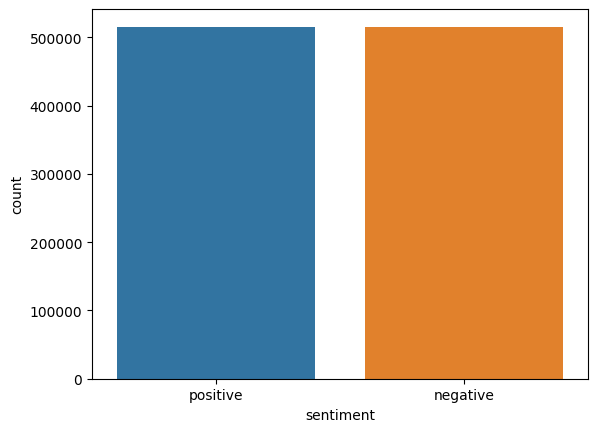

In [18]:
# Let's observe distribution of positive / negative sentiments in dataset

import seaborn as sns
sns.countplot(x='sentiment', data=movie_reviews)

## Data Preprocessing

In [25]:
movie_reviews["review"][17]

# You can see that our text contains punctuations, brackets, HTML tags and numbers
# We will preprocess this text in the next section

' We loved the location of this hotel The fact that it is set in a Park away from the busy centre of dam square was great The tram system was brilliant and easy to handle The hotel is lovely and the bed was comfy Staff were very friendly and helpful and familiarized themselves with us when they realized we travelled from Ireland '

In [26]:
TAG_RE = re.compile(r'<[^>]+>')

def remove_tags(text):
    '''Removes HTML tags: replaces anything between opening and closing <> with empty space'''

    return TAG_RE.sub('', text)

In [27]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [28]:
def preprocess_text(sen):
    '''Cleans text data up, leaving only 2 or more char long non-stepwords composed of A-Z & a-z only
    in lowercase'''

    sentence = sen.lower()

    # Remove html tags
    sentence = remove_tags(sentence)

    # Remove punctuations and numbers
    sentence = re.sub('[^a-zA-Z]', ' ', sentence)

    # Single character removal
    sentence = re.sub(r"\s+[a-zA-Z]\s+", ' ', sentence)  # When we remove apostrophe from the word "Mark's", the apostrophe is replaced by an empty space. Hence, we are left with single character "s" that we are removing here.

    # Remove multiple spaces
    sentence = re.sub(r'\s+', ' ', sentence)  # Next, we remove all the single characters and replace it by a space which creates multiple spaces in our text. Finally, we remove the multiple spaces from our text as well.

    # Remove Stopwords
    pattern = re.compile(r'\b(' + r'|'.join(stopwords.words('english')) + r')\b\s*')
    sentence = pattern.sub('', sentence)

    return sentence

In [29]:
# Calling preprocessing_text function on movie_reviews

X = []
sentences = list(movie_reviews['review'])
for sen in sentences:
    X.append(preprocess_text(sen))

In [31]:
# Sample cleaned up movie review

X[17]

# As we shall use Word Embeddings, stemming/lemmatization is not performed as a preprocessing step here

' loved location hotel fact set park away busy centre dam square great tram system brilliant easy handle hotel lovely bed comfy staff friendly helpful familiarized us realized travelled ireland '

In [32]:
# Converting sentiment labels to 0 & 1

y = movie_reviews['sentiment']

y = np.array(list(map(lambda x: 1 if x=="positive" else 0, y)))

In [33]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

# The train set will be used to train our deep learning models
# while test set will be used to evaluate how well our model performs

## Preparing embedding layer

Let's now write the script for our embedding layer. Embedding layer converts our textual data into numeric form. It is then **used as the first layer for the deep learning models in Keras**.

In [34]:
# Embedding layer expects the words to be in numeric form
# Using Tokenizer function from keras.preprocessing.text library
# Method fit_on_text trains the tokenizer
# Method texts_to_sequences converts sentences to their numeric form

word_tokenizer = Tokenizer()
word_tokenizer.fit_on_texts(X_train)

X_train = word_tokenizer.texts_to_sequences(X_train)
X_test = word_tokenizer.texts_to_sequences(X_test)

In [35]:
# Adding 1 to store dimensions for words for which no pretrained word embeddings exist

vocab_length = len(word_tokenizer.word_index) + 1

vocab_length

68263

In [36]:
# Padding all reviews to fixed length 100

maxlen = 100

X_train = pad_sequences(X_train, padding='post', maxlen=maxlen)
X_test = pad_sequences(X_test, padding='post', maxlen=maxlen)

In [37]:
# Load GloVe word embeddings and create an Embeddings Dictionary

from numpy import asarray
from numpy import zeros

embeddings_dictionary = dict()
glove_file = open('a2_glove.6B.100d.txt', encoding="utf8")

for line in glove_file:
    records = line.split()
    word = records[0]
    vector_dimensions = asarray(records[1:], dtype='float32')
    embeddings_dictionary [word] = vector_dimensions
glove_file.close()

In [38]:
# Create Embedding Matrix having 100 columns
# Containing 100-dimensional GloVe word embeddings for all words in our corpus.

embedding_matrix = zeros((vocab_length, 100))
for word, index in word_tokenizer.word_index.items():
    embedding_vector = embeddings_dictionary.get(word)
    if embedding_vector is not None:
        embedding_matrix[index] = embedding_vector

In [39]:
embedding_matrix.shape

(68263, 100)

# Model Training with:

## Simple Neural Network

In [ ]:
# Neural Network architecture

snn_model = Sequential()
embedding_layer = Embedding(vocab_length, 100, weights=[embedding_matrix], input_length=maxlen , trainable=False)

snn_model.add(embedding_layer)

snn_model.add(Flatten())
snn_model.add(Dense(1, activation='sigmoid'))

In [ ]:
# Model compiling

snn_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])

print(snn_model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 100, 100)          9239400   
                                                                 
 flatten (Flatten)           (None, 10000)             0         
                                                                 
 dense (Dense)               (None, 1)                 10001     
                                                                 
Total params: 9249401 (35.28 MB)
Trainable params: 10001 (39.07 KB)
Non-trainable params: 9239400 (35.25 MB)
_________________________________________________________________
None


In [ ]:
# Model training

snn_model_history = snn_model.fit(X_train, y_train, batch_size=128, epochs=6, verbose=1, validation_split=0.2)

Epoch 1/6
250/250 [==============================] - 2s 6ms/step - loss: 0.5596 - acc: 0.7136 - val_loss: 0.5000 - val_acc: 0.7628
Epoch 2/6
250/250 [==============================] - 1s 6ms/step - loss: 0.4483 - acc: 0.7959 - val_loss: 0.4938 - val_acc: 0.7656
Epoch 3/6
250/250 [==============================] - 2s 7ms/step - loss: 0.4120 - acc: 0.8177 - val_loss: 0.4969 - val_acc: 0.7670
Epoch 4/6
250/250 [==============================] - 2s 9ms/step - loss: 0.3909 - acc: 0.8273 - val_loss: 0.5084 - val_acc: 0.7638
Epoch 5/6
250/250 [==============================] - 2s 8ms/step - loss: 0.3739 - acc: 0.8359 - val_loss: 0.5226 - val_acc: 0.7629
Epoch 6/6
250/250 [==============================] - 2s 7ms/step - loss: 0.3639 - acc: 0.8415 - val_loss: 0.5317 - val_acc: 0.7581


In [ ]:
# Predictions on the Test Set

score = snn_model.evaluate(X_test, y_test, verbose=1)

313/313 [==============================] - 1s 2ms/step - loss: 0.5590 - acc: 0.7496


In [ ]:
# Model Performance

print("Test Score:", score[0])
print("Test Accuracy:", score[1])

Test Score: 0.5590339303016663
Test Accuracy: 0.7495999932289124


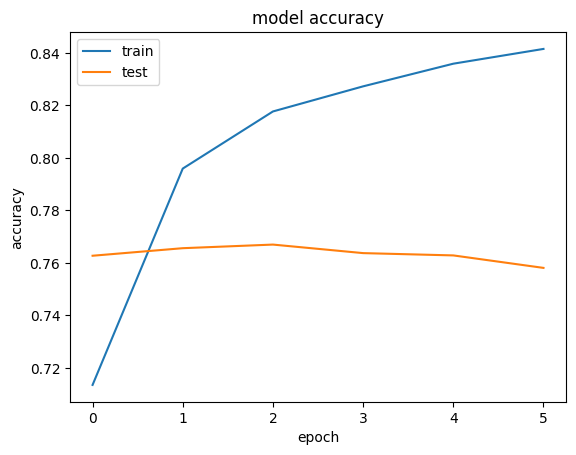

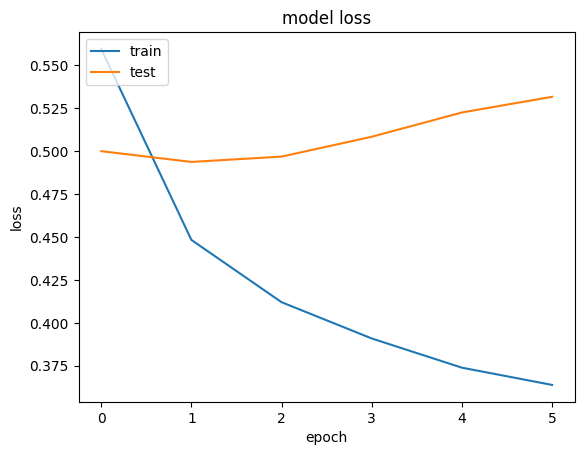

In [ ]:
# Model Performance Charts

import matplotlib.pyplot as plt

plt.plot(snn_model_history.history['acc'])
plt.plot(snn_model_history.history['val_acc'])

plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train','test'], loc='upper left')
plt.show()

plt.plot(snn_model_history.history['loss'])
plt.plot(snn_model_history.history['val_loss'])

plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train','test'], loc='upper left')
plt.show()

## Convolutional Neural Network

In [40]:
from keras.layers import Conv1D

In [41]:
# Neural Network architecture

cnn_model = Sequential()

embedding_layer = Embedding(vocab_length, 100, weights=[embedding_matrix], input_length=maxlen , trainable=False)
cnn_model.add(embedding_layer)

cnn_model.add(Conv1D(128, 5, activation='relu'))
cnn_model.add(GlobalMaxPooling1D())
cnn_model.add(Dense(1, activation='sigmoid'))

In [42]:
# Model compiling

cnn_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])
print(cnn_model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 100, 100)          6826300   
                                                                 
 conv1d (Conv1D)             (None, 96, 128)           64128     
                                                                 
 global_max_pooling1d (Glob  (None, 128)               0         
 alMaxPooling1D)                                                 
                                                                 
 dense (Dense)               (None, 1)                 129       
                                                                 
Total params: 6890557 (26.29 MB)
Trainable params: 64257 (251.00 KB)
Non-trainable params: 6826300 (26.04 MB)
_________________________________________________________________
None


In [43]:
# Model training

cnn_model_history = cnn_model.fit(X_train, y_train, batch_size=128, epochs=6, verbose=1, validation_split=0.2)

Epoch 1/6
5158/5158 [==============================] - 293s 57ms/step - loss: 0.1809 - acc: 0.9311 - val_loss: 0.1847 - val_acc: 0.9307
Epoch 2/6
5158/5158 [==============================] - 291s 56ms/step - loss: 0.1562 - acc: 0.9415 - val_loss: 0.1723 - val_acc: 0.9338
Epoch 3/6
5158/5158 [==============================] - 291s 56ms/step - loss: 0.1466 - acc: 0.9453 - val_loss: 0.1601 - val_acc: 0.9402
Epoch 4/6
5158/5158 [==============================] - 290s 56ms/step - loss: 0.1396 - acc: 0.9481 - val_loss: 0.1604 - val_acc: 0.9410
Epoch 5/6
5158/5158 [==============================] - 291s 56ms/step - loss: 0.1339 - acc: 0.9503 - val_loss: 0.1692 - val_acc: 0.9370
Epoch 6/6
5158/5158 [==============================] - 291s 56ms/step - loss: 0.1293 - acc: 0.9519 - val_loss: 0.1669 - val_acc: 0.9404


In [45]:
# Predictions on the Test Set

score = cnn_model.evaluate(X_test, y_test, verbose=1)

6447/6447 [==============================] - 45s 7ms/step - loss: 0.1654 - acc: 0.9410


In [46]:
# Model Performance

print("Test Score:", score[0])
print("Test Accuracy:", score[1])

Test Score: 0.16544298827648163
Test Accuracy: 0.9410167932510376


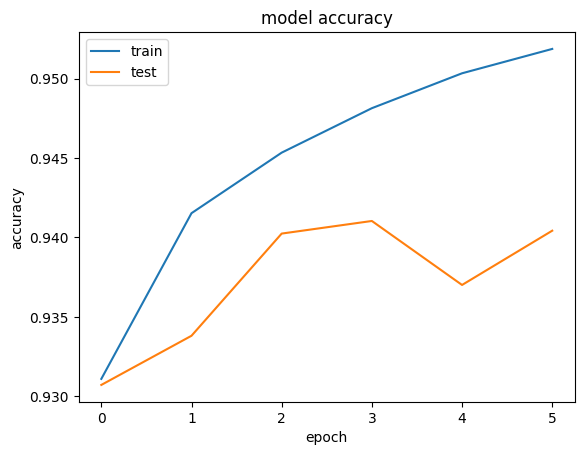

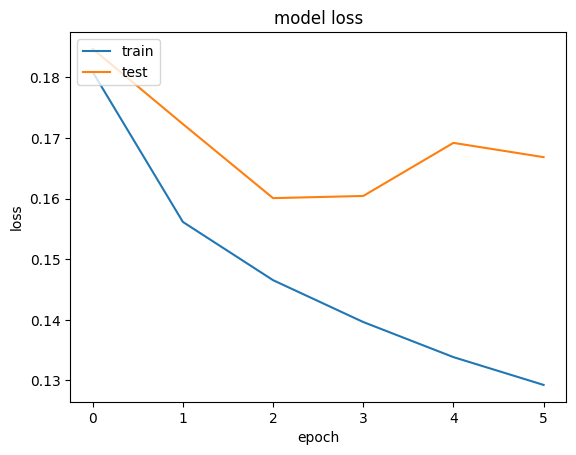

In [47]:
# Model Performance Charts

import matplotlib.pyplot as plt

plt.plot(cnn_model_history.history['acc'])
plt.plot(cnn_model_history.history['val_acc'])

plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train','test'], loc = 'upper left')
plt.show()

plt.plot(cnn_model_history.history['loss'])
plt.plot(cnn_model_history.history['val_loss'])

plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train','test'], loc = 'upper left')
plt.show()

## Recurrent Neural Network (LSTM)

In [48]:
from keras.layers import LSTM

In [49]:
# Neural Network architecture

lstm_model = Sequential()
embedding_layer = Embedding(vocab_length, 100, weights=[embedding_matrix], input_length=maxlen , trainable=False)

lstm_model.add(embedding_layer)
lstm_model.add(LSTM(128))

lstm_model.add(Dense(1, activation='sigmoid'))

In [50]:
# Model compiling

lstm_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])
print(lstm_model.summary())

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 100, 100)          6826300   
                                                                 
 lstm (LSTM)                 (None, 128)               117248    
                                                                 
 dense_1 (Dense)             (None, 1)                 129       
                                                                 
Total params: 6943677 (26.49 MB)
Trainable params: 117377 (458.50 KB)
Non-trainable params: 6826300 (26.04 MB)
_________________________________________________________________
None


In [51]:
# Model Training

lstm_model_history = lstm_model.fit(X_train, y_train, batch_size=128, epochs=6, verbose=1, validation_split=0.2)

Epoch 1/6
5158/5158 [==============================] - 1069s 207ms/step - loss: 0.3958 - acc: 0.7598 - val_loss: 0.1652 - val_acc: 0.9390
Epoch 2/6
5158/5158 [==============================] - 1110s 215ms/step - loss: 0.1620 - acc: 0.9404 - val_loss: 0.1505 - val_acc: 0.9429
Epoch 3/6
5158/5158 [==============================] - 1115s 216ms/step - loss: 0.1510 - acc: 0.9445 - val_loss: 0.1514 - val_acc: 0.9450
Epoch 4/6
5158/5158 [==============================] - 1066s 207ms/step - loss: 0.1516 - acc: 0.9444 - val_loss: 0.1466 - val_acc: 0.9460
Epoch 5/6
5158/5158 [==============================] - 1066s 207ms/step - loss: 0.1402 - acc: 0.9487 - val_loss: 0.1457 - val_acc: 0.9474
Epoch 6/6
5158/5158 [==============================] - 1068s 207ms/step - loss: 0.1352 - acc: 0.9507 - val_loss: 0.1465 - val_acc: 0.9478


In [52]:
# Predictions on the Test Set

score = lstm_model.evaluate(X_test, y_test, verbose=1)

6447/6447 [==============================] - 211s 33ms/step - loss: 0.1445 - acc: 0.9481


In [53]:
# Model Performance

print("Test Score:", score[0])
print("Test Accuracy:", score[1])

Test Score: 0.1445181518793106
Test Accuracy: 0.9480794668197632


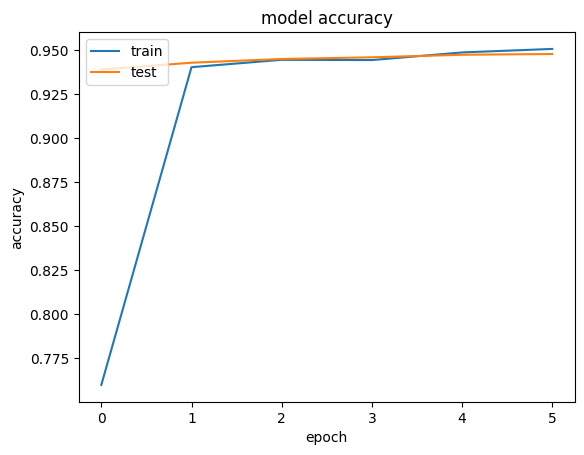

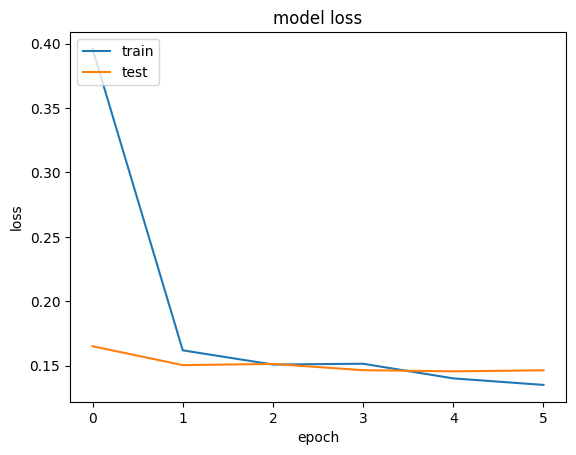

In [54]:
# Model Performance Charts

import matplotlib.pyplot as plt

plt.plot(lstm_model_history.history['acc'])
plt.plot(lstm_model_history.history['val_acc'])

plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train','test'], loc='upper left')
plt.show()

plt.plot(lstm_model_history.history['loss'])
plt.plot(lstm_model_history.history['val_loss'])

plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train','test'], loc='upper left')
plt.show()

In [55]:
# Saving the model as a h5 file for possible use later

lstm_model.save(f"./c1_lstm_model_acc_{round(score[1], 3)}.h5", save_format='h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


# Making Predictions on Live IMDb data

In [56]:
!ls # lists files in working directory

 a1_IMDB_Dataset.csv		 c1_lstm_model_acc_0.85.h5	 'hotel reviews.csv'
 a2_glove.6B.100d.txt		 c1_lstm_model_acc_0.948.h5	 'RNN Results.csv'
'attraction spots reviews.csv'	 c2_IMDb_Unseen_Predictions.csv
 c1_lstm_model_acc_0.836.h5	'CNN Results.csv'


In [57]:
# # Load previously trained LSTM Model

# from keras.models import load_model

# model_path ='./c1_lstm_model_acc_0.856.h5'
# pretrained_lstm_model = load_model(model_path)

# # summarize model.
# pretrained_lstm_model.summary()

In [58]:
# Load sample IMDb reviews csv, having ~6 movie reviews, along with their IMDb rating

sample_reviews = pd.read_csv("attraction spots reviews.csv")

#sample_reviews.head(6)

In [59]:
# Preprocess review text with earlier defined preprocess_text function

unseen_reviews = sample_reviews['Review Text']

unseen_processed = []
for review in unseen_reviews:
  review = preprocess_text(review)
  unseen_processed.append(review)

In [60]:
# Tokenising instance with earlier trained tokeniser
unseen_tokenized = word_tokenizer.texts_to_sequences(unseen_processed)

# Pooling instance to have maxlength of 100 tokens
unseen_padded = pad_sequences(unseen_tokenized, padding='post', maxlen=maxlen)

In [61]:
unseen_sentiments = cnn_model.predict(unseen_padded)

#unseen_sentiments

855/855 [==============================] - 7s 8ms/step


In [63]:
# Passing tokenised instance to the LSTM model for predictions
unseen_sentiments = lstm_model.predict(unseen_padded)

#unseen_sentiments

855/855 [==============================] - 32s 37ms/step


In [65]:
# Writing model output file back to Google Drive

sample_reviews['Raw Predicted Sentiments'] = unseen_sentiments
sample_reviews['Predicted Sentiments'] = np.round(unseen_sentiments*10,1)

df_raw_prediction_sentiments = pd.DataFrame(sample_reviews['Raw Predicted Sentiments'], columns = ['Raw Predicted Sentiments'])
df_prediction_sentiments = pd.DataFrame(sample_reviews['Predicted Sentiments'], columns = ['Predicted Sentiments'])
df_movie                 = pd.DataFrame(sample_reviews['Spot'], columns = ['Spot'])
df_review_text           = pd.DataFrame(sample_reviews['Review Text'], columns = ['Review Text'])
df_imdb_rating           = pd.DataFrame(sample_reviews['Rating'], columns = ['Rating'])


dfx=pd.concat([df_movie, df_review_text, df_imdb_rating, df_raw_prediction_sentiments, df_prediction_sentiments], axis=1)

dfx.to_csv("./RNN Results 2.csv", sep=',', encoding='UTF-8')

dfx.head(6)

,Spot,Review Text,Rating,Raw Predicted Sentiments,Predicted Sentiments
0,Cox's Bazar Beach,"To be brutally honest, this “beach” is not eve...",1,0.006918,0.1
1,Cox's Bazar Beach,On of the best beaches I have visited. I will ...,5,0.982113,9.8
2,Cox's Bazar Beach,Cox's Bazar is a mesmerizing coastal gem! Its ...,5,0.614604,6.1
3,Cox's Bazar Beach,The beach was beautiful. Clean white sand and ...,5,0.996582,10.0
4,Cox's Bazar Beach,The first longest sea beach in Asia is Cox's B...,5,0.989670,9.9
5,Cox's Bazar Beach,Enjoying the sea is one of my favorite hobbies...,5,0.989351,9.9
